### Investigation of Top Mass Reweighting

This notebook investigates DCTR reweighting performance on top mass daset

* We use only the hadronic mass as input data and top mass as parameter
* We use 5 layers DNN which is comparable to the Gaussian reweighting version
* The model is tested on reweighting from both particle and detector datasets

### Imports

In [185]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [186]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras


import inspect

### Helper Functions

In [187]:
def normalize_mt(top_mass):
    return (top_mass-170)/10

### Load the truth data for top mass 172.5 and split 80% for training and 20% for testing

In [188]:
default_had_mass_all = np.load(data_dir + 'part_172_5_6j_obs.npy')[:,1]
default_had_mass = default_had_mass_all[:int(len(default_had_mass_all)*0.8)]
test_had_mass = default_had_mass_all[int(len(default_had_mass_all)*0.8):]

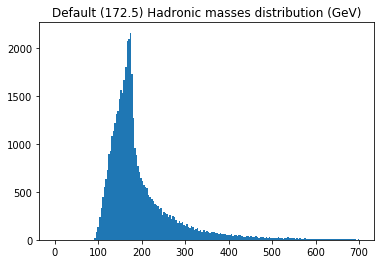

In [189]:
plt.hist(default_had_mass, bins = np.linspace(0,700,200))
plt.title("Default (172.5) Hadronic masses distribution (GeV)")
plt.show()

In [190]:
truth_had_mass = np.load(data_dir+ 'part_varmass_6j_obs.npy')[:,1][:len(default_had_mass)]

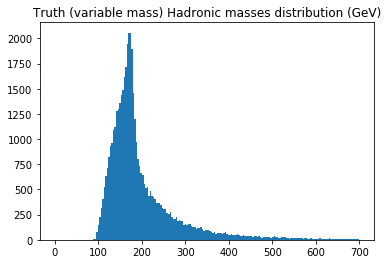

In [191]:
plt.hist(truth_had_mass, bins = np.linspace(0,700,200))
plt.title("Truth (variable mass) Hadronic masses distribution (GeV)")
plt.show()

### Plot the distribution of top mass (should be uniformly around 170-180)

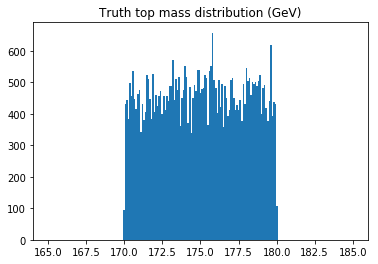

In [192]:
mu_values = np.load(data_dir+ 'part_varmass_6j.npy')[:,0,-1][:len(default_had_mass)]
plt.hist(mu_values, bins = np.linspace(165,185,200))
plt.title("Truth top mass distribution (GeV)")
plt.show()

### Prepare sample for DCTR reweighting

In [193]:
X0 = list(zip(default_had_mass, normalize_mt(mu_values)))
Y0 = to_categorical(np.zeros(len(X0)), num_classes=2)

In [194]:
X1 = list(zip(truth_had_mass,normalize_mt(mu_values)))
Y1 = to_categorical(np.ones(len(X1)), num_classes=2)

In [195]:
X = np.concatenate((X0, X1))
Y = np.concatenate((Y0, Y1))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

### Define a 5 layer DNN for reweighting

In [196]:
inputs = Input((2,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
hidden_layer_4 = Dense(50, activation='relu')(hidden_layer_3)
hidden_layer_5 = Dense(50, activation='relu')(hidden_layer_4)

outputs = Dense(2, activation='softmax')(hidden_layer_5)

dctr_model = Model(inputs = inputs, outputs = outputs)
dctr_model.compile(loss='categorical_crossentropy', optimizer='Adam')

In [197]:
dctr_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                150       
_________________________________________________________________
dense_16 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_17 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_18 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_19 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 102       
Total para

In [198]:
earlystopping = EarlyStopping(patience = 10,
                              restore_best_weights=True)
dctr_model.fit(X_train, Y_train, 
          epochs=20, 
          batch_size = 100,
          validation_data = (X_test, Y_test),
          callbacks = [earlystopping])


Train on 73868 samples, validate on 18468 samples
Epoch 1/20
73868/73868 [==============================] - 5s 70us/step - loss: 0.7485 - val_loss: 0.7029
Epoch 2/20
73868/73868 [==============================] - 5s 63us/step - loss: 0.6979 - val_loss: 0.6940
Epoch 3/20
73868/73868 [==============================] - 5s 64us/step - loss: 0.6946 - val_loss: 0.6959
Epoch 4/20
73868/73868 [==============================] - 5s 63us/step - loss: 0.6941 - val_loss: 0.6931
Epoch 5/20
73868/73868 [==============================] - 5s 64us/step - loss: 0.6936 - val_loss: 0.6935
Epoch 6/20
73868/73868 [==============================] - 5s 63us/step - loss: 0.6933 - val_loss: 0.6931
Epoch 7/20
73868/73868 [==============================] - 5s 63us/step - loss: 0.6932 - val_loss: 0.6932
Epoch 8/20
73868/73868 [==============================] - 5s 62us/step - loss: 0.6932 - val_loss: 0.6933
Epoch 9/20
73868/73868 [==============================] - 5s 63us/step - loss: 0.6932 - val_loss: 0.6931
Epoch

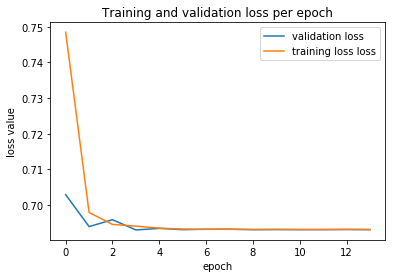

In [199]:
plt.title("Training and validation loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss value")
plt.plot(dctr_model.history.history['val_loss'], label = "validation loss")
plt.plot(dctr_model.history.history['loss'], label = "training loss loss")
plt.legend()
plt.show()

## Reweighting from data of mass 175 to 172.5 

### Reweighting of particle dataset

In [200]:
X0_test = np.vstack([test_had_mass,normalize_mt(172.5)*np.ones(len(test_had_mass))]).T
X1_test = np.load(data_dir + 'part_175_0_6j_obs.npy')[:,1][:len(X0_test)]
X1_test = np.vstack([X1_test,normalize_mt(175)*np.ones(len(X1_test))]).T

In [201]:
# Get predicted probabilities
preds_0 = dctr_model.predict(X0_test, batch_size=1000)
preds_1 = dctr_model.predict(X1_test, batch_size=1000)

In [202]:
weights_0 = preds_0[:,0]/preds_0[:,1]
weights_1 = preds_1[:,0]/preds_1[:,1]

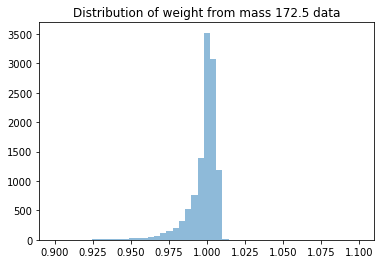

In [203]:
bins = np.linspace(0.9,1.1,50)
plt.hist(weights_0, bins = bins, alpha = 0.5)[0]
plt.title("Distribution of weight from mass 172.5 data")
plt.show()

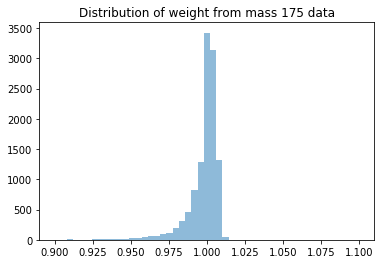

In [204]:
bins = np.linspace(0.9,1.1,50)
plt.hist(weights_1, bins = bins, alpha = 0.5)[0]
plt.title("Distribution of weight from mass 175 data")
plt.show()

In [205]:
print(max(weights_0))
print(max(1/weights_0))
print(max(weights_1))
print(max(1/weights_1))

1.0107421
1.2288884
1.0116868
1.1820271


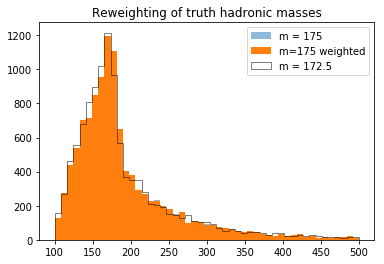

In [206]:
bins = np.linspace(100,500,50)
plt.title("Reweighting of truth hadronic masses")

target_data_hist = plt.hist(X1_test[:,0], bins = bins, alpha = 0.5, label = 'm = 175')[0]
reweight_data_hist = plt.hist(X1_test[:,0], bins = bins, label = 'm=175 weighted', weights=weights_1)[0]
default_data_hist = plt.hist(X0_test[:,0], bins = bins, alpha = 0.5, label = 'm = 172.5',histtype='step', color='k')[0]
plt.legend()
plt.show()

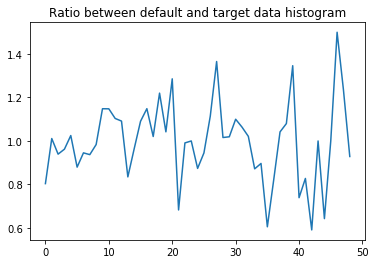

In [207]:
plt.title("Ratio between default and target data histogram")
plt.plot(target_data_hist/default_data_hist)
plt.show()

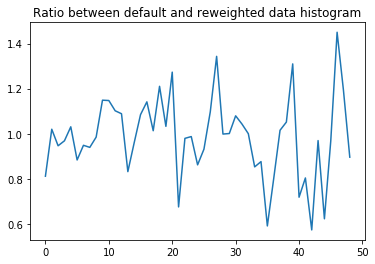

In [208]:
plt.title("Ratio between default and reweighted data histogram")
plt.plot(reweight_data_hist/default_data_hist)
plt.show()

### Reweighting of detector datasets

In [209]:
X0_test = np.load(data_dir + 'det_172_5_6j_obs.npy')[:,1][int(len(default_had_mass_all)*0.8):]
X0_test = np.vstack([X0_test,normalize_mt(172.5)*np.ones(len(X0_test))]).T
X1_test = np.load(data_dir + 'det_175_0_6j_obs.npy')[:,1][:len(X0_test)]
X1_test = np.vstack([X1_test,normalize_mt(175)*np.ones(len(X1_test))]).T

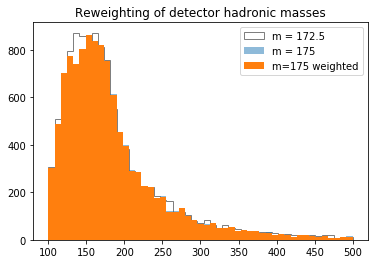

In [210]:
bins = np.linspace(100,500,50)
plt.title("Reweighting of detector hadronic masses")
default_data_hist = plt.hist(X0_test[:,0], bins = bins, alpha = 0.5, label = 'm = 172.5',histtype='step', color='k')[0]
target_data_hist = plt.hist(X1_test[:,0], bins = bins, alpha = 0.5, label = 'm = 175')[0]
reweight_data_hist = plt.hist(X1_test[:,0], bins = bins, label = 'm=175 weighted', weights=weights_1)[0]
plt.legend()
plt.show()

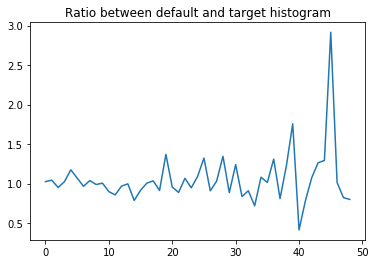

In [211]:
plt.title("Ratio between default and target histogram")
plt.plot(default_data_hist/reweight_data_hist)
plt.show()